# preparing

In [42]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly
import functions
from preprocess_dataframe import get_preprocess_dataframe
import os
import re
import glob
import math
import plotly.graph_objs as go
from shutil import copyfile
import time

## prepare paths

In [43]:
cycle_test=19

In [44]:
times=20

In [45]:
main_path='/media/alena/ext_space/job_analyze'
disabled_path="{}/disabled_folder{}".format(main_path,cycle_test)
frozen_path='{}/frozen_folder{}'.format(main_path,cycle_test)
learn_path='{}/learn_folder{}'.format(main_path,cycle_test)

## prepare func import dataframes

In [46]:
def readcsv(args):
    return pd.read_csv(args, header=None)

def get_df(path_folder,mode,times):
    
    df_ex_pl_time = pd.DataFrame()
    df_ex_pl_time_orig = pd.DataFrame()
    df_explains_plans = pd.DataFrame()
    df_query_err=pd.DataFrame()
    df_query_stat=pd.DataFrame()
    df_query_data=pd.DataFrame()
    filename_basics=glob.glob("{}/*_report.csv".format(path_folder, mode))
    if mode !='disabled':
        filename_others=['{}/{}_aqo_data.csv'.format(path_folder,mode), '{}/{}_aqo_query_stat.csv'.format(path_folder,mode)] 
        dfs = [df_query_data,df_query_err, df_query_stat]
    
    #print(filename_basics)
    for file in filename_basics:
        df_list = list(pd.read_csv(file) for file in filename_basics)
        if len(df_list)>1:
            df_list = []
            for file in filename_basics:
                df=pd.read_csv(file)
                df['Query hash'] = df['Query hash'].astype(str)
                df_list.append(df)
            df_ex_pl_time = pd.concat(df_list, ignore_index=True)
        else:
            df_ex_pl_time = df_list[0]
    if mode !='disabled':
        for k,file in enumerate(filename_others):
            dfs[k] = pd.read_csv(file)
    
    #explains
    dict_q={}
    dict_q_text={}
    lst=[]
    q=''
    plan=''
    k=0
    with open('{}/explains.txt'.format(path_folder)) as f:
        for line in f:
            str_=line
            if str_.replace(' ','')=='':
                continue
            if str_.find("QUERY PLAN")==0:
                if q not in list(dict_q.keys()):
                    dict_q[q]=1
                    dict_q_text[q]=[]
                    dict_q_text[q].append(re.sub(r'<b>\((.+)\)</b>', r'<b>\1</b>', str_))
                    #dict_q[q].append(str_)
                else:
                    str_=re.sub(r'<b>\((.+)\)</b>', r'<b>\1</b>', str_)
                    for i in list(dict_q_text[q]):
                        if i==str_:
                            dict_q[q]+=1
                            dict_q_text[q].append(str_)
                            break
                    #dict_q[q].append(str_)
                q=''
            else:
                q+=str_
    
    df_explains_plans = pd.DataFrame(dict_q.items())
    df_explains_plans.columns=['query_string', 'plans']
    #lst=[]
    #for i in df_explains_plans.itertuples(index=False):
    #    lst.append(len(i.plans)>1)
    #df_explains_plans['changed']=lst

    #report
    df_ex_pl_time = df_ex_pl_time.fillna(0)
    print(df_ex_pl_time)
    df_ex_pl_time = df_ex_pl_time.rename(columns = {'Plan time': 'plan_time',
                                         'Query Number':'query_number', 
                                         'Query Name':'query_name', 
                                         'Execution Time':'execution_time', 
                                         'Query hash':'query_hash'})
    df_ex_pl_time['query_number'] = df_ex_pl_time['query_number'].astype(int)
    df_ex_pl_time['query_hash'] = df_ex_pl_time['query_hash'].astype(str)
    df_ex_pl_time['plan_time'] = df_ex_pl_time['plan_time'].astype(float)
    df_ex_pl_time_orig=df_ex_pl_time.copy()
    if times>1:
        lst_data = []
        dict_query = {}
        for i in df_ex_pl_time.itertuples(index=False):
            if i.query_name in dict_query:
                dict_query[i.query_name][1] += i.execution_time
                dict_query[i.query_name][3] += i.plan_time
            else:
                dict_query[i.query_name] = [i.query_name, i.execution_time, i.query_hash, i.plan_time]
        df_ex_pl_time = pd.DataFrame(dict_query.values(), columns = ['query_name', 'execution_time', 'query_hash', 'plan_time'])
        df_ex_pl_time['exec_time_avg'] = df_ex_pl_time['execution_time']/times
        df_ex_pl_time['plan_time_avg'] = df_ex_pl_time['plan_time']/times
    
    if mode !='disabled':
        #err
        filename_basics=glob.glob("{}/*_err*.csv".format(path_folder, mode))
        lst=[]
        df_list=[]
        def f(lst,k,l):
            lst_temp=[k]*l
            lst = lst+lst_temp
        #for file in filename_basics:
            #for iteration,file in enumerate(filename_basics):
            #    df_list.append(pd.read_csv(file))
            #    lst_temp=[iteration]*len(df_list)
            #    lst = lst+lst_temp
        df_list = list(pd.read_csv(file) for file in filename_basics)
        if len(df_list)>1:
            df_query_err = pd.concat(df_list, ignore_index=True)
        else:
            df_query_err = df_list[0]
        #df_list['iteration']=lst
        #print(df_query_err.columns)
        df_query_err['id'] = df_query_err['id'].astype(str)
        df_query_err['errdelta'] = df_query_err['errdelta'].astype(float)
    
        #stat
        df_query_stat=dfs[1].fillna(0)
        lst_stat_columns = ['execution_time_with_aqo', 'execution_time_without_aqo',
           'planning_time_with_aqo', 'planning_time_without_aqo',
           'cardinality_error_with_aqo', 'cardinality_error_without_aqo']
        lst_stat_cut = [1, 1, 1, 1, 1, 1]
        df_query_stat = get_preprocess_dataframe(df_query_stat, lst_stat_columns, lst_stat_cut)
        lst_min_val_with_aqo = []
        lst_min_iter_with_aqo = []
        for i in df_query_stat.itertuples(index=False):
            min_val = 100000
            iteration = -1
            for k,val in enumerate(i.cardinality_error_with_aqo_split):
                if val < 0.1:
                    if min_val>val:
                        min_val = val
                        iteration = k
                    break
            lst_min_val_with_aqo.append(min_val)
            lst_min_iter_with_aqo.append(iteration)
        df_query_stat['min_iter_card_with'] = lst_min_iter_with_aqo
        df_query_stat['lst_min_val_with_aqo'] = lst_min_val_with_aqo
        

        lst_min_val_without_aqo = []
        lst_min_iter_without_aqo = []
        for i in df_query_stat.itertuples(index=False):
            min_val = 100000
            iteration = -1
            for k,val in enumerate(i.cardinality_error_without_aqo_split):
                if min_val > val:
                    min_val = val
                    iteration = k
            lst_min_val_without_aqo.append(min_val)
            lst_min_iter_without_aqo.append(iteration)
        df_query_stat['min_iter_card_without'] = lst_min_iter_without_aqo
        df_query_stat['lst_min_val_without_aqo'] = lst_min_val_without_aqo

        lst_min_val_with_aqo = []
        lst_min_iter_with_aqo = []
        for i in df_query_stat.itertuples(index=False):
            min_val = 100000
            iteration = -1
            for k,val in enumerate(i.execution_time_with_aqo_split):
                if min_val>val:
                    min_val = val
                    iteration = k
            lst_min_val_with_aqo.append(min_val)
            lst_min_iter_with_aqo.append(iteration)
        df_query_stat['min_iter_exec_with'] = lst_min_iter_with_aqo
        df_query_stat['lst_min_exec_with_aqo'] = lst_min_val_with_aqo

        lst_columns = ['cardinality_error_without_aqo_split', 'cardinality_error_with_aqo_split']
        lst_columns_with = ['planning_time_with_aqo_split', 'execution_time_with_aqo_split']
        lst_columns_without = ['planning_time_without_aqo_split', 'execution_time_without_aqo_split']
        for i,j,k in zip(lst_columns, lst_columns_with, lst_columns_without):
            df_query_stat = functions.last_errors(df_query_stat, i, '{}_last_value'.format(i))
            df_query_stat = functions.last_errors(df_query_stat, j,'{}_last_value'.format(i))
            df_query_stat = functions.last_errors(df_query_stat, k,'{}_last_value'.format(i))
        
        dict_hash = {}
        for i in df_ex_pl_time.itertuples(index=False):
            if i.query_hash in dict_hash:
                dict_hash[str(i.query_hash)].append(i.query_name)
            else:
                dict_hash[i.query_hash] = []
                dict_hash[str(i.query_hash)].append(i.query_name)
        df_temp=pd.DataFrame(dict_hash.items())
        df_temp.columns=['queryid', 'query_name']
        df_temp['queryid'] = df_temp['queryid'].astype(str)
        df_query_stat['queryid'] = df_query_stat['queryid'].astype(str)
        #print(df_query_stat.columns)
        df_query_stat=df_query_stat.merge(df_temp, how='left', on='queryid')
        df_query_err=df_query_err.merge(df_temp,left_on='id', right_on='queryid')
        df_query_err['query_name'] = df_query_err['query_name'].astype(str)
        df_query_stat['query_name'] = df_query_stat['query_name'].astype(str)
        df_query_err=df_query_err.drop(columns=['queryid'])
    
    if mode !='disabled':
        return df_explains_plans, df_ex_pl_time, df_ex_pl_time_orig, df_query_err, df_query_stat
    else:
        return df_explains_plans, df_ex_pl_time

In [47]:
learn_df_explains_plans, learn_df_ex_pl_time, learn_df_ex_pl_time_orig, learn_df_query_err, learn_df_query_stat=get_df(learn_path,'learn',times)

      Query Number Query Name  Execution Time  Plan time            Query hash
0               16    10a.sql         243.548     46.006  -6651533820180303979
1               16    10b.sql         130.168     33.505    988535410010893112
2               16    10c.sql       11786.147     28.554   2494719406442254794
3               16    11a.sql         215.839     70.598  -8754961486292191806
4               16    11b.sql          32.582     60.508   7102013096890644952
...            ...        ...             ...        ...                   ...
2142             7     8d.sql        3049.597     41.021  -2444720784039749802
2143             7     9a.sql        2050.938     92.474  -6747521538659772949
2144             7     9b.sql        2213.923    117.289    316739818532851506
2145             7     9c.sql        2220.512     90.819   -180252288200201541
2146             7     9d.sql       15733.589     67.244   7221379846823333251

[2147 rows x 5 columns]


/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['{}_split'.format('{}'.format(column_name))].loc[k] = list(map(get_elements,i.split(',')))
/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['{}_split'.format('{}'.format(column_name))].loc[k] = list(map(get_elements,i.split(',')))
/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [48]:
disabled_df_explains_plans, disabled_df_ex_pl_time=get_df(disabled_path,'disabled',1)

     Query Number Query Name  Execution Time  Plan time           Query hash
0               1    10a.sql        3072.919     38.708 -6651533820180303979
1               1    10b.sql         185.816     26.333   988535410010893112
2               1    10c.sql       15847.336     17.243  2494719406442254794
3               1    11a.sql         122.237     47.651 -8754961486292191806
4               1    11b.sql          28.824     28.789  7102013096890644952
..            ...        ...             ...        ...                  ...
108             1     8d.sql        4810.985     24.507 -2444720784039749802
109             1     9a.sql        4598.531     37.526 -6747521538659772949
110             1     9b.sql        1804.470     38.337   316739818532851506
111             1     9c.sql        1973.279     37.693  -180252288200201541
112             1     9d.sql       16633.647     34.139  7221379846823333251

[113 rows x 5 columns]


In [49]:
frozen_df_explains_plans, frozen_df_ex_pl_time, frozen_df_ex_pl_time_orig, frozen_df_query_err, frozen_df_query_stat=get_df(frozen_path,'frozen',1)

     Query Number Query Name  Execution Time  Plan time           Query hash
0               1    10a.sql         246.174     26.918 -6651533820180303979
1               1    10b.sql         121.876     28.086   988535410010893112
2               1    10c.sql       11738.968     28.764  2494719406442254794
3               1    11a.sql         207.111     70.722 -8754961486292191806
4               1    11b.sql          31.056     57.565  7102013096890644952
..            ...        ...             ...        ...                  ...
108             1     8d.sql        2801.408     35.002 -2444720784039749802
109             1     9a.sql        1726.076     75.847 -6747521538659772949
110             1     9b.sql        1867.638     64.844   316739818532851506
111             1     9c.sql        1938.409     73.993  -180252288200201541
112             1     9d.sql       11453.784     63.941  7221379846823333251

[113 rows x 5 columns]


/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['{}_split'.format('{}'.format(column_name))].loc[k] = list(map(get_elements,i.split(',')))
/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['{}_split'.format('{}'.format(column_name))].loc[k] = list(map(get_elements,i.split(',')))
/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [50]:
frozen_df_ex_pl_time

query_number query_name  execution_time  plan_time            query_hash
0               1    10a.sql         246.174     26.918  -6651533820180303979
1               1    10b.sql         121.876     28.086    988535410010893112
2               1    10c.sql       11738.968     28.764   2494719406442254794
3               1    11a.sql         207.111     70.722  -8754961486292191806
4               1    11b.sql          31.056     57.565   7102013096890644952
..            ...        ...             ...        ...                   ...
108             1     8d.sql        2801.408     35.002  -2444720784039749802
109             1     9a.sql        1726.076     75.847  -6747521538659772949
110             1     9b.sql        1867.638     64.844    316739818532851506
111             1     9c.sql        1938.409     73.993   -180252288200201541
112             1     9d.sql       11453.784     63.941   7221379846823333251

[113 rows x 5 columns]

In [51]:
frozen_df_ex_pl_time[frozen_df_ex_pl_time['query_name']=='32a.sql']

query_number query_name  execution_time  plan_time           query_hash
82             1    32a.sql          19.836     30.806  6225652705960457954

## Main report analyze

In [52]:
frozen_df_ex_pl_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   query_number    113 non-null    int64  
 1   query_name      113 non-null    object 
 2   execution_time  113 non-null    float64
 3   plan_time       113 non-null    float64
 4   query_hash      113 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 4.5+ KB


In [53]:
# frozen_df_ex_pl_time, frozen_df_ex_pl_time, frozen_df_query_err, frozen_df_query_stat

In [54]:
def renames(df, mode):
    df = df.rename(columns = {'plan_time':'plan_time_{}'.format(mode), 'execution_time':'execution_time_{}'.format(mode)})
    if mode == 'control' or mode == 'disabled':
        df = df.rename(columns = {'plan_time_avg':'plan_time_avg_{}'.format(mode), 'exec_time_avg':'exec_time_avg_{}'.format(mode)})
    return df

In [55]:
frozen_df_ex_pl_time=renames(frozen_df_ex_pl_time,'frozen')


In [56]:
disabled_df_ex_pl_time=renames(disabled_df_ex_pl_time,'disabled')

In [57]:
learn_df_ex_pl_time=renames(learn_df_ex_pl_time,'learn')

In [58]:
disabled_df_ex_pl_time

query_number query_name  execution_time_disabled  plan_time_disabled  \
0               1    10a.sql                 3072.919              38.708   
1               1    10b.sql                  185.816              26.333   
2               1    10c.sql                15847.336              17.243   
3               1    11a.sql                  122.237              47.651   
4               1    11b.sql                   28.824              28.789   
..            ...        ...                      ...                 ...   
108             1     8d.sql                 4810.985              24.507   
109             1     9a.sql                 4598.531              37.526   
110             1     9b.sql                 1804.470              38.337   
111             1     9c.sql                 1973.279              37.693   
112             1     9d.sql                16633.647              34.139   

               query_hash  
0    -6651533820180303979  
1      988535410010893112  
2     2494719406442254794  
3    -8754961486292191806  
4     7102013096890644952  
..                    ...  
108  -2444720784039749802  
109  -6747521538659772949  
110    316739818532851506  
111   -180252288200201541  
112   7221379846823333251  

[113 rows x 5 columns]

In [59]:
df_ex_pl_time = frozen_df_ex_pl_time.merge(disabled_df_ex_pl_time, how='left', on=['query_name','query_number','query_hash'])

In [60]:
#df = df.merge(learn_df_ex_pl_time, how='left', on=['query_name','query_hash'])

In [61]:
df_ex_pl_time

query_number query_name  execution_time_frozen  plan_time_frozen  \
0               1    10a.sql                246.174            26.918   
1               1    10b.sql                121.876            28.086   
2               1    10c.sql              11738.968            28.764   
3               1    11a.sql                207.111            70.722   
4               1    11b.sql                 31.056            57.565   
..            ...        ...                    ...               ...   
108             1     8d.sql               2801.408            35.002   
109             1     9a.sql               1726.076            75.847   
110             1     9b.sql               1867.638            64.844   
111             1     9c.sql               1938.409            73.993   
112             1     9d.sql              11453.784            63.941   

               query_hash  execution_time_disabled  plan_time_disabled  
0    -6651533820180303979                 3072.919              38.708  
1      988535410010893112                  185.816              26.333  
2     2494719406442254794                15847.336              17.243  
3    -8754961486292191806                  122.237              47.651  
4     7102013096890644952                   28.824              28.789  
..                    ...                      ...                 ...  
108  -2444720784039749802                 4810.985              24.507  
109  -6747521538659772949                 4598.531              37.526  
110    316739818532851506                 1804.470              38.337  
111   -180252288200201541                 1973.279              37.693  
112   7221379846823333251                16633.647              34.139  

[113 rows x 7 columns]

In [62]:
learn_df_ex_pl_time_orig

query_number query_name  execution_time  plan_time            query_hash
0               16    10a.sql         243.548     46.006  -6651533820180303979
1               16    10b.sql         130.168     33.505    988535410010893112
2               16    10c.sql       11786.147     28.554   2494719406442254794
3               16    11a.sql         215.839     70.598  -8754961486292191806
4               16    11b.sql          32.582     60.508   7102013096890644952
...            ...        ...             ...        ...                   ...
2142             7     8d.sql        3049.597     41.021  -2444720784039749802
2143             7     9a.sql        2050.938     92.474  -6747521538659772949
2144             7     9b.sql        2213.923    117.289    316739818532851506
2145             7     9c.sql        2220.512     90.819   -180252288200201541
2146             7     9d.sql       15733.589     67.244   7221379846823333251

[2147 rows x 5 columns]

## err_data

In [63]:
frozen_df_query_err

id  errdelta   query_name
0   -9026514954839072455  1.494240  ['12a.sql']
1   -8754961486292191806  0.999876  ['11a.sql']
2   -7994933085961275538  1.152227  ['23b.sql']
3   -7971004576533452411  1.351723  ['21c.sql']
4   -7678011977838348522  1.664412   ['7c.sql']
..                   ...       ...          ...
90   7519382914444524780  2.399770  ['31a.sql']
91   7721649514993682563  0.723232  ['30b.sql']
92   7915967579038312663  1.719173  ['19d.sql']
93   9105500078934324812  3.255533  ['25c.sql']
94   9106003620751043838  2.088460   ['5a.sql']

[95 rows x 3 columns]

In [64]:
def renames(df, mode, column):
    df = df.rename(columns = {column:'{}_{}'.format(column,mode)})
    return df

In [65]:
learn_df_query_err=renames(learn_df_query_err,'learn','errdelta')

In [66]:
frozen_df_query_err=renames(frozen_df_query_err,'frozen','errdelta')

In [67]:
df_err = learn_df_query_err.merge(frozen_df_query_err, how='left', on=['id', 'query_name'])

In [68]:
df_err

id  errdelta_learn                      query_name  \
0       988535410010893112        0.000000                     ['10b.sql']   
1       988535410010893112        0.000000                     ['10b.sql']   
2       988535410010893112        0.000000                     ['10b.sql']   
3       988535410010893112        0.000000                     ['10b.sql']   
4       988535410010893112        1.192016                     ['10b.sql']   
...                    ...             ...                             ...   
1895  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   
1896  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   
1897  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   
1898  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   
1899  -1950505845315524548        0.972260  ['4a.sql', '4b.sql', '4c.sql']   

      errdelta_frozen  
0            1.192016  
1            1.192016  
2            1.192016  
3            1.192016  
4            1.192016  
...               ...  
1895         1.054515  
1896         1.054515  
1897         1.054515  
1898         1.054515  
1899         1.054515  

[1900 rows x 4 columns]

## learn_df_query_stat

In [69]:
learn_df_query_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 18 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   queryid                                         95 non-null     object 
 1   cardinality_error_without_aqo_split             95 non-null     object 
 2   cardinality_error_with_aqo_split                95 non-null     object 
 3   planning_time_without_aqo_split                 95 non-null     object 
 4   planning_time_with_aqo_split                    95 non-null     object 
 5   execution_time_without_aqo_split                95 non-null     object 
 6   execution_time_with_aqo_split                   95 non-null     object 
 7   executions_with_aqo                             95 non-null     int64  
 8   executions_without_aqo                          95 non-null     int64  
 9   min_iter_card_with                           

In [70]:
learn_df_query_stat

queryid                cardinality_error_without_aqo_split  \
0     988535410010893112                               [1.1920162521349358]   
1   -6651533820180303979                               [0.7105221546183831]   
2   -3414057395363075461                               [0.9142991861305755]   
3    3350265702090035455                                [3.320400539746125]   
4    -917204397272063480                               [3.2532766876167556]   
..                   ...                                                ...   
90  -6885312641126422993                                [2.432780391028795]   
91  -1889760809355916724                                [3.878764741758613]   
92  -6571914703387389993                               [1.4433860920428911]   
93   -460740518707800565                               [0.9172237323564743]   
94  -1950505845315524548  [0.9798792819060133, 0.4465750798771107, 1.066...   

                     cardinality_error_with_aqo_split  \
0   [1.4616438610722509, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1   [0.7252818076369754, 0.20549283755296058, 0.0,...   
2   [1.1885889419697482, 0.07701635339554948, 0.0,...   
3   [3.328155086529966, 2.169516763311445, 1.63167...   
4   [3.2451247839101067, 1.929014613036643, 0.9614...   
..                                                ...   
90  [2.4598668792784237, 0.14398478283858396, 0.0,...   
91  [3.8980541334568604, 2.07591186854257, 1.62768...   
92  [1.442780107563711, 0.8152581027671788, 0.3884...   
93  [0.9151338759225511, 0.400222974922172, 0.1683...   
94  [0.011538125913381528, 0.025015150933378454, 0...   

            planning_time_without_aqo_split  \
0                             [0.026226381]   
1                             [0.038574397]   
2                              [0.00951821]   
3                             [0.036294517]   
4                             [0.026380421]   
..                                      ...   
90                            [0.010389252]   
91                            [0.268594185]   
92                            [0.355609697]   
93                            [0.059932303]   
94  [0.012113558, 0.010165716, 0.007382274]   

                         planning_time_with_aqo_split  \
0   [0.025728534, 0.034151752, 0.029958985, 0.0326...   
1   [0.026729975, 0.045033516, 0.043947282, 0.0364...   
2   [0.014897705, 0.019820551, 0.019289104, 0.0211...   
3   [0.05537461, 0.063729789, 0.057718043, 0.05385...   
4   [0.040071053, 0.037738631, 0.05410122, 0.04827...   
..                                                ...   
90  [0.016478576, 0.017556968, 0.014725684, 0.0186...   
91  [2.814191886, 2.879825109, 2.803110182, 3.3700...   
92  [5.495706637, 5.5486344800000005, 5.424678184,...   
93  [0.168418759, 0.117927609, 0.113566399, 0.1187...   
94  [0.019315479, 0.018423491, 0.016807807, 0.0166...   

          execution_time_without_aqo_split  \
0                            [0.187048844]   
1                            [3.074049318]   
2                            [0.251953644]   
3                           [59.048628536]   
4                           [39.300135908]   
..                                     ...   
90                           [0.148272395]   
91                           [3.680271928]   
92                           [0.158255094]   
93                           [0.952334969]   
94  [0.219311858, 0.156207202, 0.24007977]   

                        execution_time_with_aqo_split  executions_with_aqo  \
0   [0.126813568, 0.133724676, 0.131687125, 0.1326...                   19   
1   [0.239489298, 0.243184827, 0.239045452, 0.2491...                   19   
2   [0.267958071, 0.239078817, 0.23965747, 0.24344...                   19   
3   [52.251277021, 133.378548425, 129.004908858, 1...                   19   
4   [29.479915858, 19.65142842, 28.269399508, 112....                   19   
..                                                ...                  ...   
90  [0.144502533, 0.150565069, 0.1

# build graphs: learning

In [71]:
def upload_pics(contain, dir_to, filename):
    plotly.offline.plot(contain, image_filename=filename, image='svg')
    time.sleep(10)
    #os.replace('{}/{}.svg'.format('/home/alena/Downloads', filename), '{}/{}.svg'.format(dir_to, filename))

## err for every query

### err_data

In [72]:
learn_df_query_err

id  errdelta_learn                      query_name
0       988535410010893112        0.000000                     ['10b.sql']
1       988535410010893112        0.000000                     ['10b.sql']
2       988535410010893112        0.000000                     ['10b.sql']
3       988535410010893112        0.000000                     ['10b.sql']
4       988535410010893112        1.192016                     ['10b.sql']
...                    ...             ...                             ...
1895  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']
1896  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']
1897  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']
1898  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']
1899  -1950505845315524548        0.972260  ['4a.sql', '4b.sql', '4c.sql']

[1900 rows x 3 columns]

In [73]:
lst_queries=learn_df_query_err['id'].unique()

In [74]:
lst=[]
for k in range(times):
    lst += [k]*len(lst_queries)
    if len(lst)==len(learn_df_query_err):
        break

In [75]:
len(lst), len(learn_df_query_err)

(1900, 1900)

In [76]:
learn_df_query_err['iter']=lst

In [77]:
name_query = list(learn_df_query_err['query_name'].unique())

In [78]:
from plotly.subplots import make_subplots

In [79]:
ox=list(x for x in range(times))

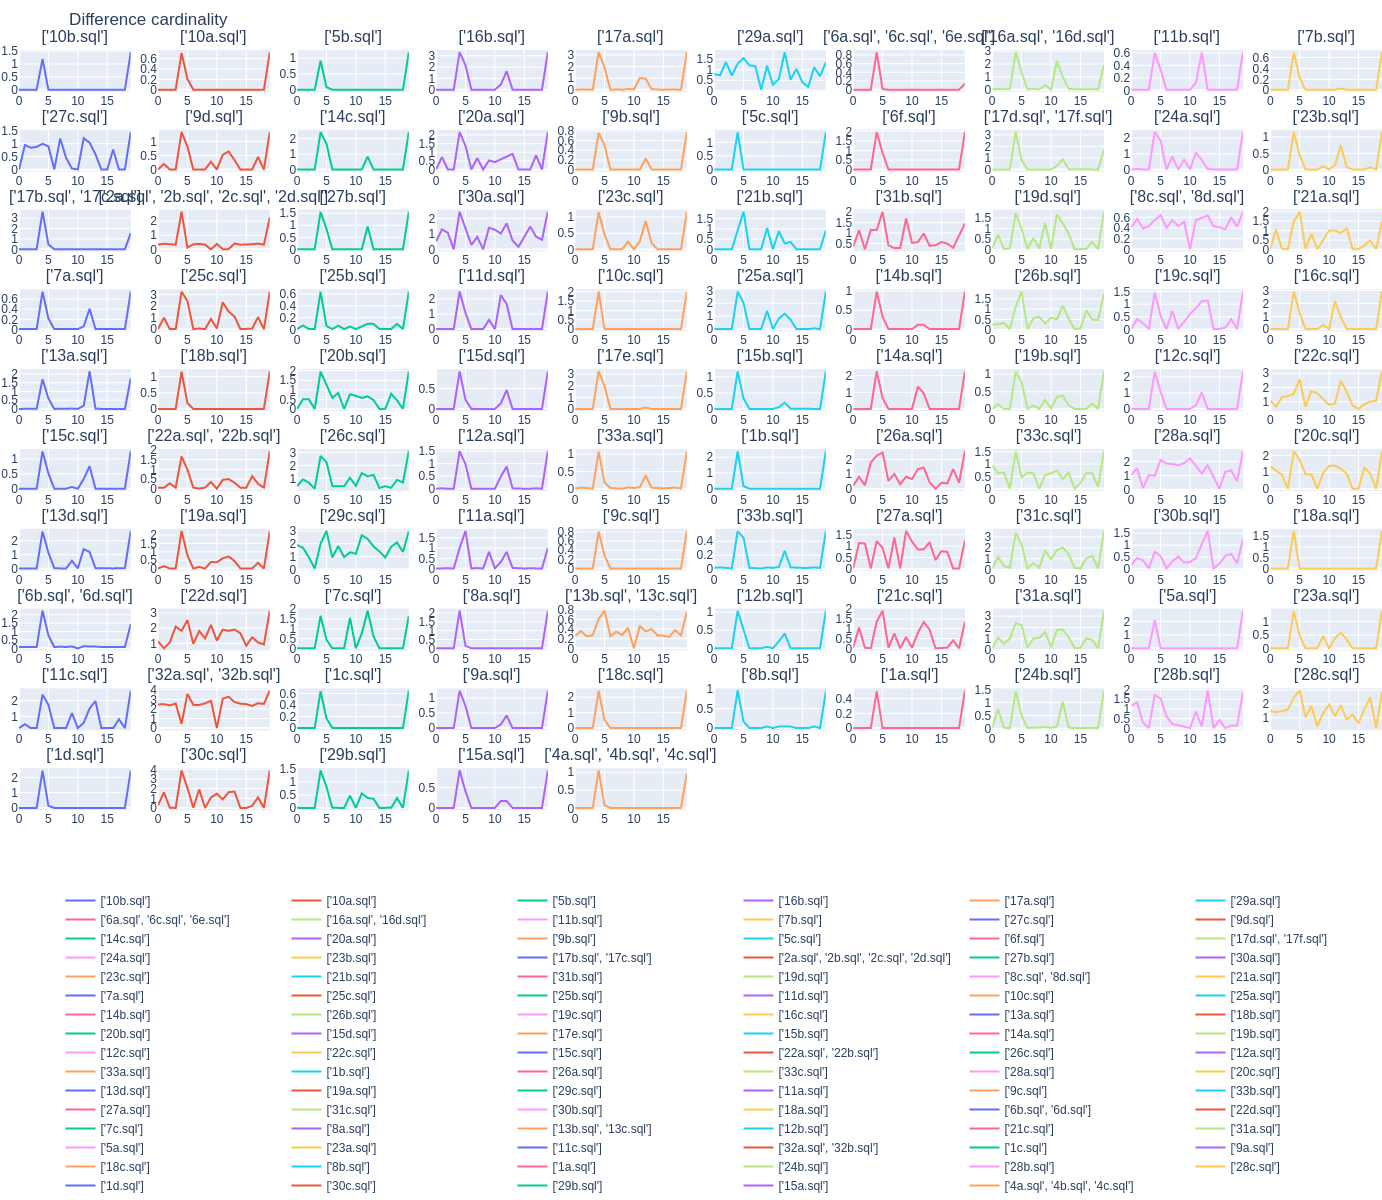

In [80]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_err[learn_df_query_err['query_name']==i]
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['errdelta_learn']),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                   title_text="Difference cardinality",
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
#upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Difference cardinality')
fig.show()

### query_stats

In [81]:
name_query=list(learn_df_query_stat['query_name'])

In [82]:
df_temp=learn_df_query_stat[learn_df_query_stat['query_name']=="['15a.sql']"]

In [83]:
oy=df_temp['cardinality_error_with_aqo_split'].to_list()

In [84]:
ox=list(x for x in range(len(df_temp['cardinality_error_with_aqo_split'].to_list()[0])))

In [85]:
ox

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [86]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_stat[learn_df_query_stat['query_name']==i]
    ox=list(x for x in range(len(df_temp['cardinality_error_with_aqo_split'].to_list()[0][:-1])))
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['cardinality_error_with_aqo_split'].to_list()[0][:-1]),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(title_text="Error cardinality for learn by aqo_query_stat",
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Error cardinality for learn by aqo_query_stat')
#fig.show()

Found ffmpeg: /opt/yandex/browser-beta/libffmpeg.so
	avcodec: 3877988
	avformat: 3874916
	avutil: 3744870
Ffmpeg version is OK! Let's use it.
[789890:789890:0329/005759.501973:ERROR:isolated_origin_util.cc(74)] Ignoring port number in isolated origin: chrome://custo


Opening in existing browser session.


libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)


## execution for every query

### learn_df_ex_pl_time_orig

In [146]:
name_query = list(learn_df_query_err['query_name'].unique())

In [147]:
ox=list(x for x in range(times))

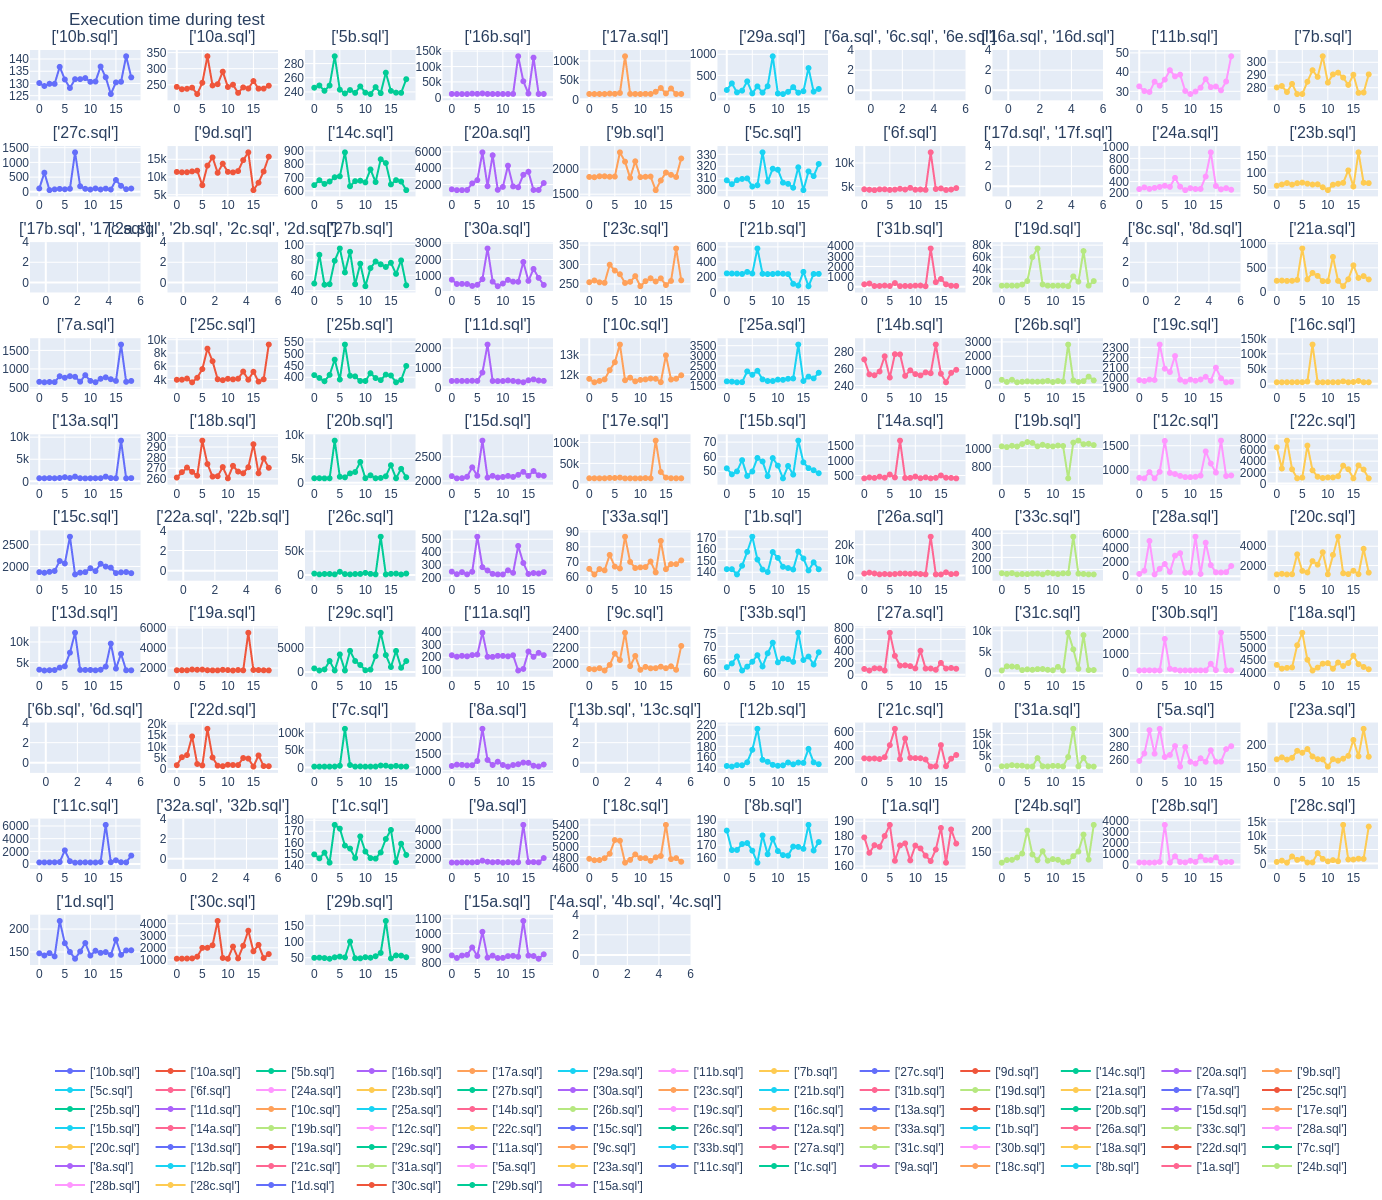

In [148]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_ex_pl_time_orig[learn_df_ex_pl_time_orig['query_name']==i[2:-2]]
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['execution_time']),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  title_text="Execution time during test",
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
#upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Execution time during test')
fig.show()

### learn_df_query_stat

In [149]:
name_query=list(learn_df_query_stat['query_name'])

In [150]:
df_temp=learn_df_query_stat[learn_df_query_stat['query_name']=="['15a.sql']"]

In [151]:
ox=list(x for x in range(len(df_temp['execution_time_with_aqo_split'].to_list()[0])))

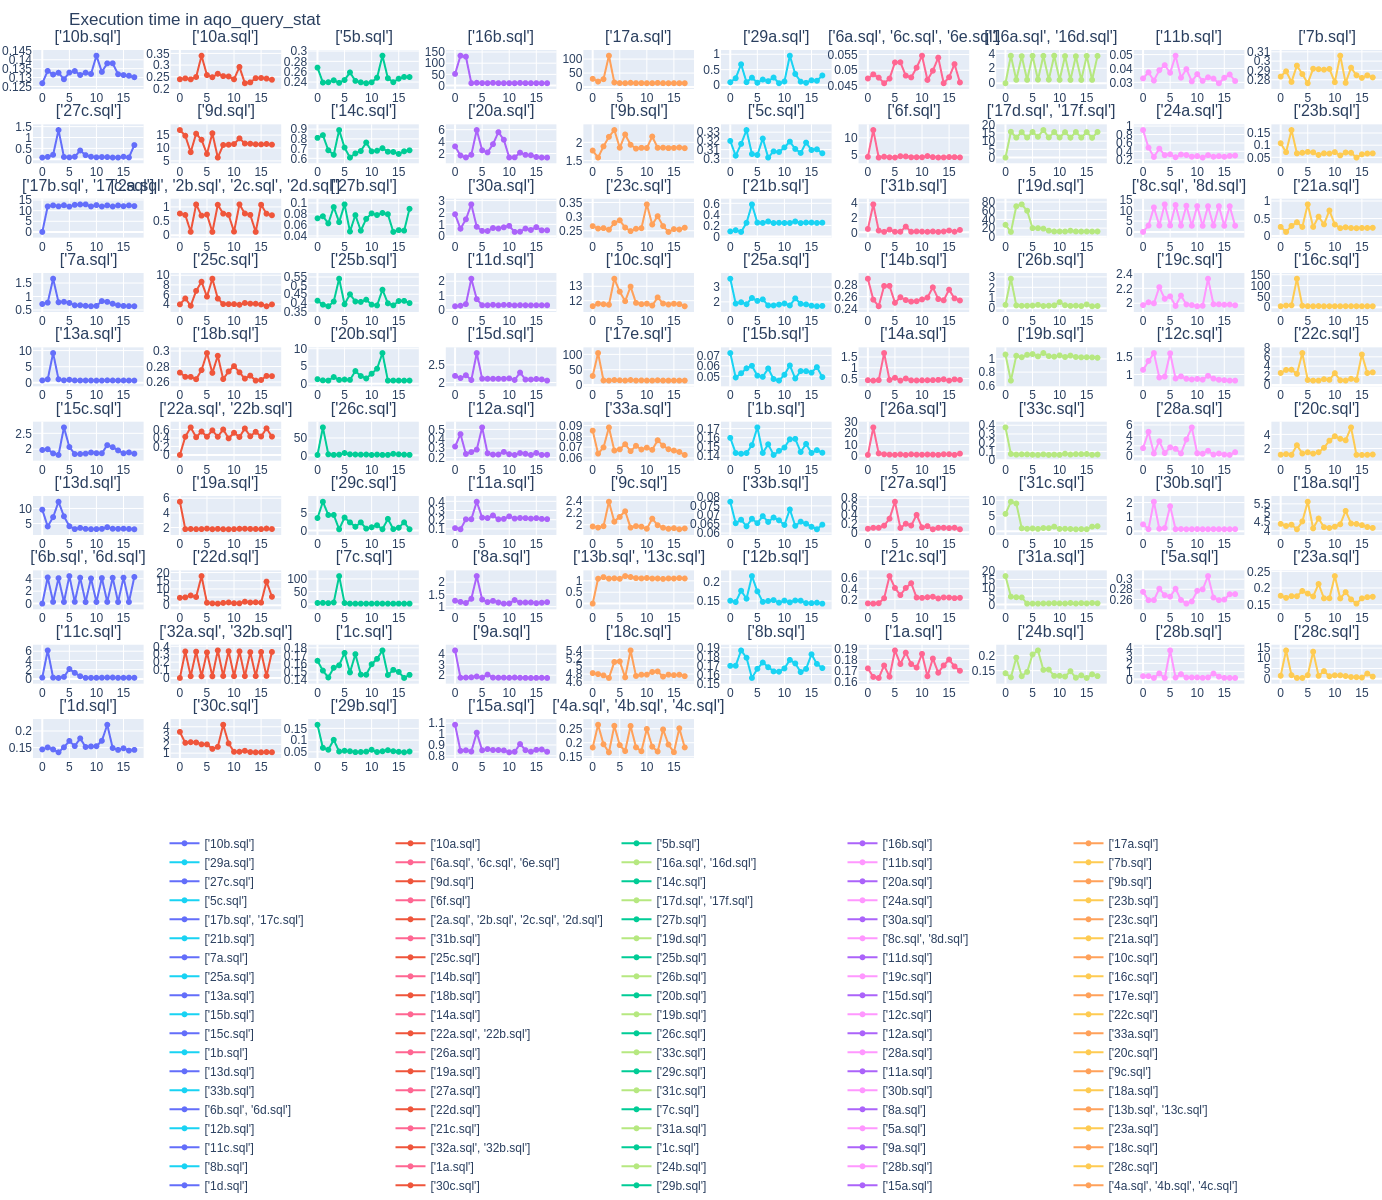

In [152]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_stat[learn_df_query_stat['query_name']==i]
    ox=list(x for x in range(len(df_temp['execution_time_with_aqo_split'].to_list()[0][:-1])))
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['execution_time_with_aqo_split'].to_list()[0][:-1]),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  title_text="Execution time in aqo_query_stat",
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
#upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Execution time in aqo_query_stat')
fig.show()

## plan for every query

### learn_df_ex_pl_time_orig

In [153]:
name_query = list(learn_df_query_err['query_name'].unique())

In [154]:
ox=list(x for x in range(times))

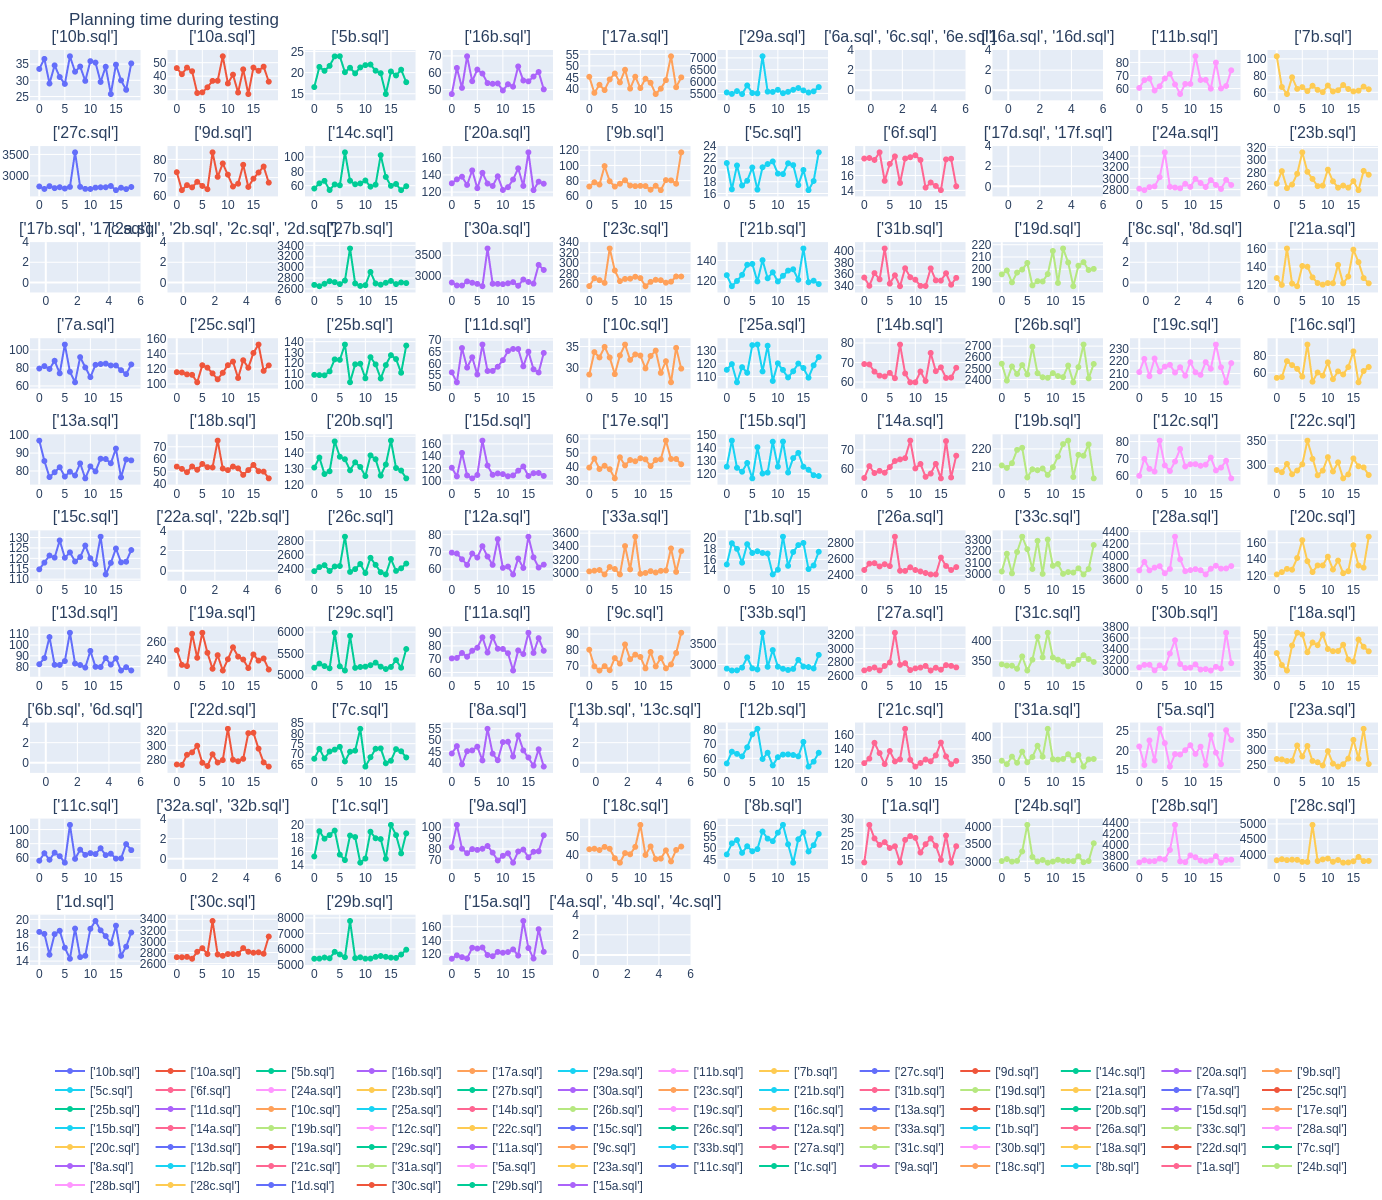

In [155]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_ex_pl_time_orig[learn_df_ex_pl_time_orig['query_name']==i[2:-2]]
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['plan_time']),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  title='Planning time during testing',
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
#upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Planning time during testing')
fig.show()

### aqo_query_stat

In [156]:
name_query=list(learn_df_query_stat['query_name'])

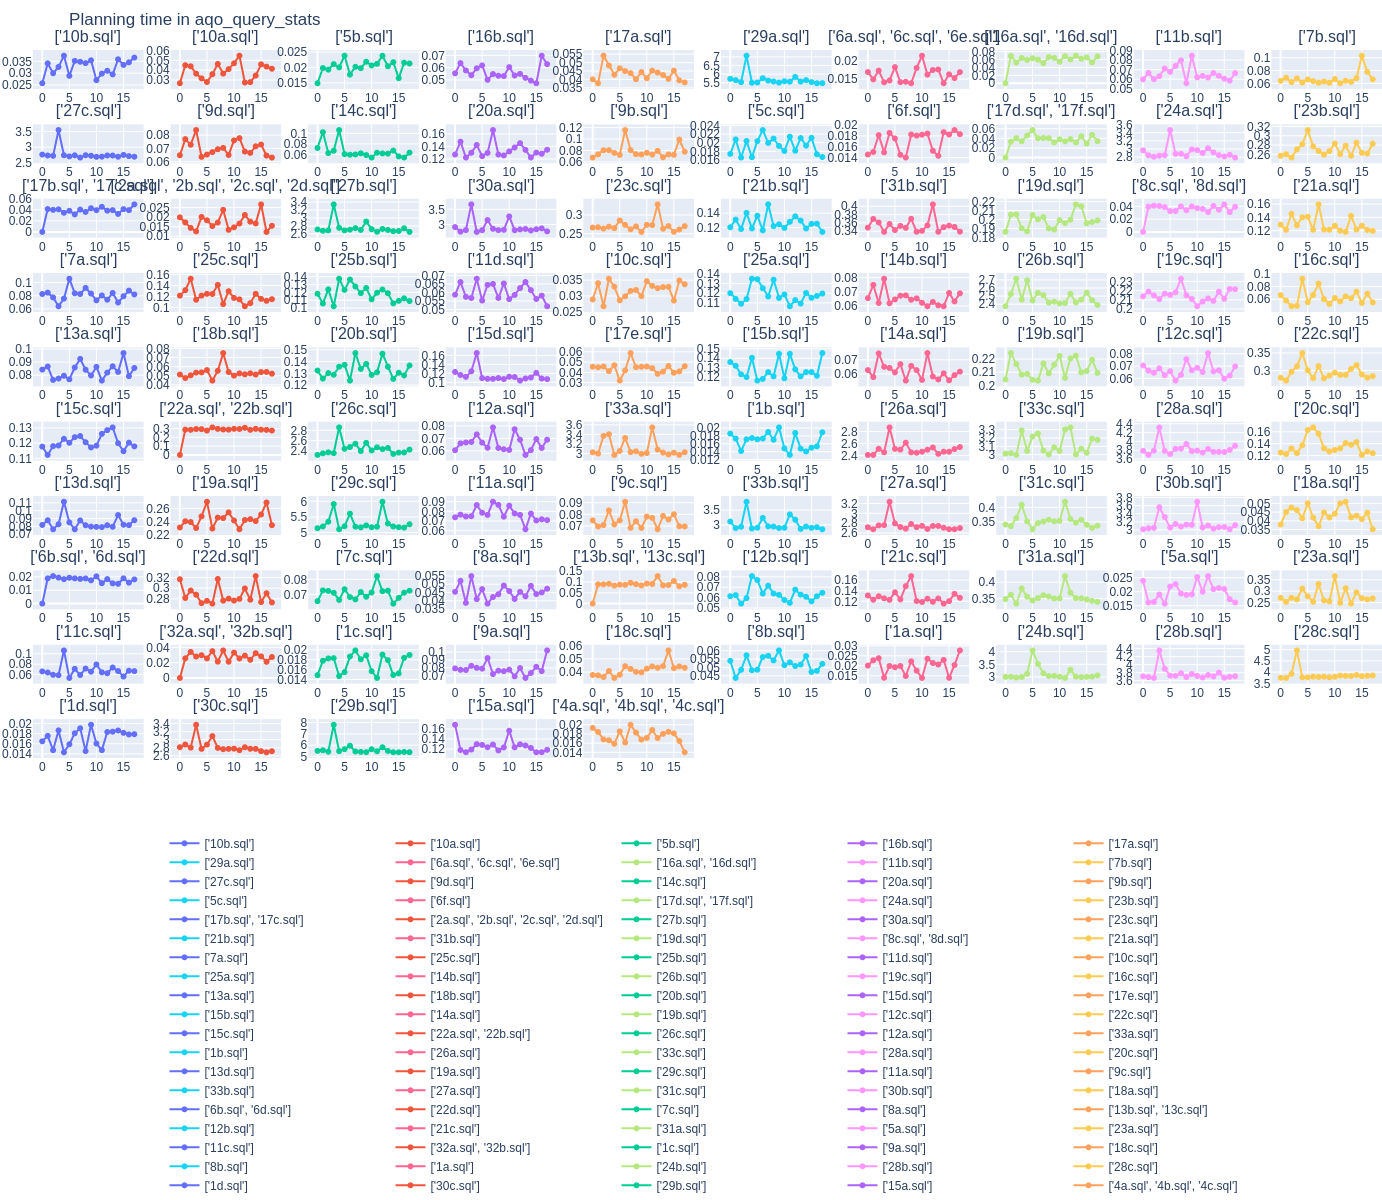

In [157]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_stat[learn_df_query_stat['query_name']==i]
    ox=list(x for x in range(len(df_temp['planning_time_with_aqo_split'].to_list()[0][:-1])))
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['planning_time_with_aqo_split'].to_list()[0][:-1]),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title='Planning time in aqo_query_stats',
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
#upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Planning time during testing')
fig.show()

# build graphs: disabled and control

## query with plan and execution time

### df_ex_pl_time

In [158]:
df_ex_pl_time_copy=df_ex_pl_time.copy()

In [159]:
df_ex_pl_time_copy

query_number query_name  execution_time_frozen  plan_time_frozen  \
0               1    10a.sql                246.174            26.918   
1               1    10b.sql                121.876            28.086   
2               1    10c.sql              11738.968            28.764   
3               1    11a.sql                207.111            70.722   
4               1    11b.sql                 31.056            57.565   
..            ...        ...                    ...               ...   
108             1     8d.sql               2801.408            35.002   
109             1     9a.sql               1726.076            75.847   
110             1     9b.sql               1867.638            64.844   
111             1     9c.sql               1938.409            73.993   
112             1     9d.sql              11453.784            63.941   

               query_hash  execution_time_disabled  plan_time_disabled  
0    -6651533820180303979                 3072.919              38.708  
1      988535410010893112                  185.816              26.333  
2     2494719406442254794                15847.336              17.243  
3    -8754961486292191806                  122.237              47.651  
4     7102013096890644952                   28.824              28.789  
..                    ...                      ...                 ...  
108  -2444720784039749802                 4810.985              24.507  
109  -6747521538659772949                 4598.531              37.526  
110    316739818532851506                 1804.470              38.337  
111   -180252288200201541                 1973.279              37.693  
112   7221379846823333251                16633.647              34.139  

[113 rows x 7 columns]

In [160]:
df_ex_pl_time_copy['diff_exec_time']=df_ex_pl_time_copy['execution_time_disabled']-df_ex_pl_time_copy['execution_time_frozen']

In [161]:
df_ex_pl_time_copy['rate_exec_time']=df_ex_pl_time_copy['execution_time_disabled']/df_ex_pl_time_copy['execution_time_frozen']

In [162]:
df_ex_pl_time_copy['diff_plan_time']=df_ex_pl_time_copy['plan_time_disabled']-df_ex_pl_time_copy['plan_time_frozen']

In [163]:
df_ex_pl_time_copy['rate_plan_time']=df_ex_pl_time_copy['plan_time_disabled']/df_ex_pl_time_copy['plan_time_frozen']

In [164]:
exec_rate_2x=df_ex_pl_time_copy[df_ex_pl_time_copy['rate_exec_time']>=2]
plan_rate_2x=df_ex_pl_time_copy[df_ex_pl_time_copy['rate_plan_time']>=2]

In [165]:
exec_rate_1x=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_exec_time']<2) & (df_ex_pl_time_copy['rate_exec_time']>=1)]
plan_rate_1x=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_plan_time']<2) & (df_ex_pl_time_copy['rate_plan_time']>=1)]

In [166]:
exec_rate_more_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_exec_time']<1) & (df_ex_pl_time_copy['rate_exec_time']>=0)]
plan_rate_more_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_plan_time']<1) & (df_ex_pl_time_copy['rate_plan_time']>=0)]

In [167]:
exec_rate_less_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_exec_time']<0)]
plan_rate_less_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_plan_time']<0)]

In [168]:
lst_exec=[len(exec_rate_2x), len(exec_rate_1x), len(exec_rate_more_0)]
lst_plan=[len(plan_rate_2x), len(plan_rate_1x), len(plan_rate_more_0)]

Found ffmpeg: /opt/yandex/browser-beta/libffmpeg.so
	avcodec: 3877988
	avformat: 3874916
	avutil: 3744870
Ffmpeg version is OK! Let's use it.
[790282:790282:0329/010442.529832:ERROR:isolated_origin_util.cc(74)] Ignoring port number in isolated origin: chrome://custo


Opening in existing browser session.


libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)


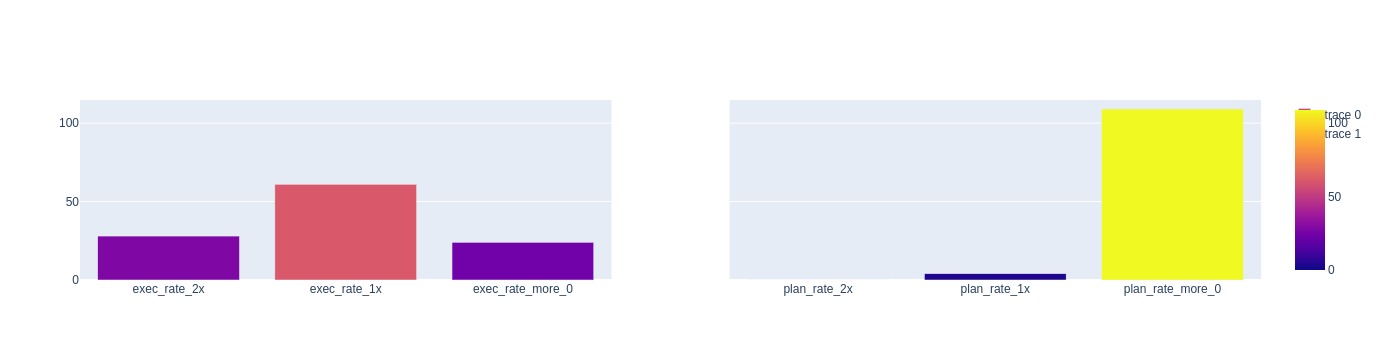

In [170]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
fig.add_trace(go.Bar(x=['exec_rate_2x', 'exec_rate_1x', 'exec_rate_more_0'], y=lst_exec,
                    marker=dict(color=lst_exec, coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x=['plan_rate_2x', 'plan_rate_1x', 'plan_rate_more_0'], y=lst_plan,
                    marker=dict(color=lst_plan, coloraxis="coloraxis")),
              1, 2)
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'execution time effective')
fig.show()

In [178]:
df_filter=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_exec_time']+df_ex_pl_time_copy['rate_plan_time'])<=4]

Found ffmpeg: /opt/yandex/browser-beta/libffmpeg.so
	avcodec: 3877988
	avformat: 3874916
	avutil: 3744870
Ffmpeg version is OK! Let's use it.
[790984:790984:0329/010647.192729:ERROR:isolated_origin_util.cc(74)] Ignoring port number in isolated origin: chrome://custo
libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)


Opening in existing browser session.


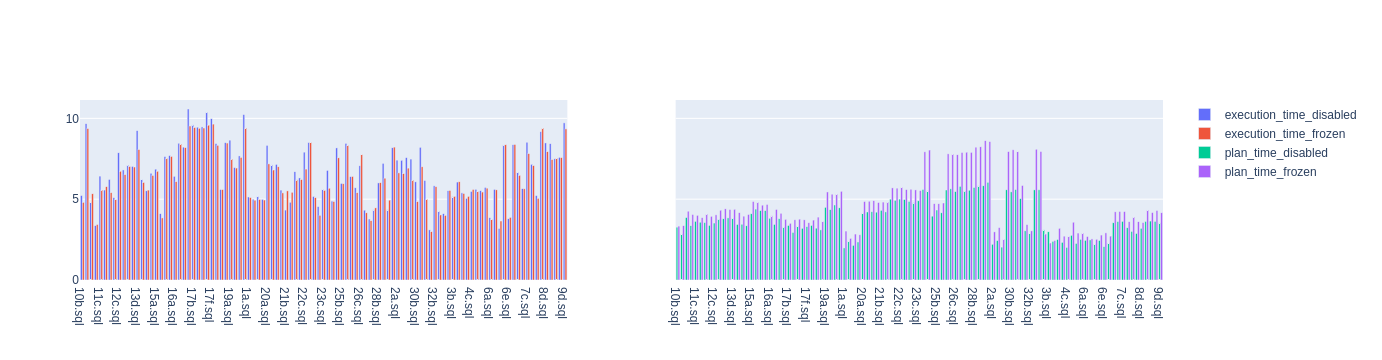

In [179]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
fig.add_trace(go.Bar(name='execution_time_disabled', x=df_filter['query_name'], y=np.log(df_filter['execution_time_disabled'])),
              1, 1)
fig.add_trace(go.Bar(name='execution_time_frozen',x=df_filter['query_name'], y=np.log(df_filter['execution_time_frozen'])),
              1, 1)
fig.add_trace(go.Bar(name='plan_time_disabled',x=df_filter['query_name'], y=np.log(df_filter['plan_time_disabled'])),
              1, 2)
fig.add_trace(go.Bar(name='plan_time_frozen',x=df_filter['query_name'], y=np.log(df_filter['plan_time_frozen'])),
              1, 2)
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Planning time and execution time difference')
fig.show()

### aqo_query_stat

In [180]:
frozen_df_query_stat_copy=frozen_df_query_stat.copy()

In [181]:
frozen_df_query_stat_copy.columns

Index(['queryid', 'cardinality_error_without_aqo_split',
       'cardinality_error_with_aqo_split', 'planning_time_without_aqo_split',
       'planning_time_with_aqo_split', 'execution_time_without_aqo_split',
       'execution_time_with_aqo_split', 'executions_with_aqo',
       'executions_without_aqo', 'min_iter_card_with', 'lst_min_val_with_aqo',
       'min_iter_card_without', 'lst_min_val_without_aqo',
       'min_iter_exec_with', 'lst_min_exec_with_aqo',
       'cardinality_error_without_aqo_split_last_value',
       'cardinality_error_with_aqo_split_last_value', 'query_name'],
      dtype='object')

In [182]:
execution_without=[]
for i in frozen_df_query_stat_copy.itertuples(index=False):
    if len(i.execution_time_without_aqo_split)==1:
        execution_without.append(i.execution_time_without_aqo_split[0])
    else:
        execution_without.append(i.execution_time_without_aqo_split[-1])

In [183]:
frozen_df_query_stat_copy['diff_exec_time']=frozen_df_query_stat_copy['execution_time_without_aqo_split'][0]-frozen_df_query_stat_copy['lst_min_exec_with_aqo']

In [184]:
frozen_df_query_stat_copy['rate_exec_time']=frozen_df_query_stat_copy['execution_time_without_aqo_split'][0]/frozen_df_query_stat_copy['lst_min_exec_with_aqo']

In [185]:
frozen_df_query_stat_copy['execution_time_without_aqo_split']

0                              [0.187048844]
1                              [3.074049318]
2                              [0.251953644]
3                             [59.048628536]
4                             [39.300135908]
                       ...                  
90                             [0.148272395]
91                             [3.680271928]
92                             [0.158255094]
93                             [0.952334969]
94    [0.219311858, 0.156207202, 0.24007977]
Name: execution_time_without_aqo_split, Length: 95, dtype: object

In [186]:
exec_rate_2x=frozen_df_query_stat_copy[frozen_df_query_stat_copy['rate_exec_time']>=2]

In [187]:
exec_rate_1x=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_exec_time']<2) & (frozen_df_query_stat_copy['rate_exec_time']>=1)]

In [188]:
exec_rate_more_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_exec_time']<1) & (frozen_df_query_stat_copy['rate_exec_time']>=0)]

In [189]:
exec_rate_less_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_exec_time']<0)]

In [190]:
lst_exec=[len(exec_rate_2x), len(exec_rate_1x), len(exec_rate_more_0)]

Found ffmpeg: /opt/yandex/browser-beta/libffmpeg.so
	avcodec: 3877988
	avformat: 3874916
	avutil: 3744870
Ffmpeg version is OK! Let's use it.
[791194:791194:0329/010800.848657:ERROR:isolated_origin_util.cc(74)] Ignoring port number in isolated origin: chrome://custo


Opening in existing browser session.


libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)


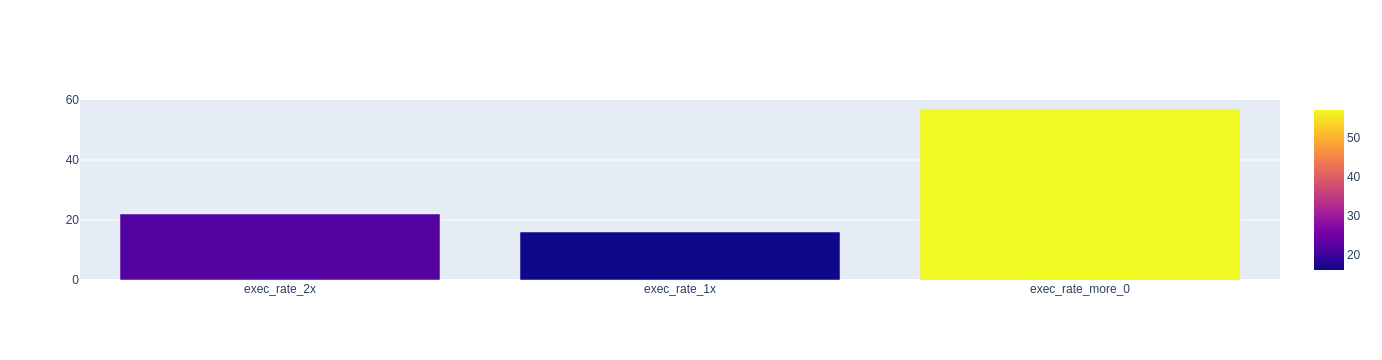

In [192]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['exec_rate_2x', 'exec_rate_1x', 'exec_rate_more_0'], y=lst_exec,
                    marker=dict(color=lst_exec, coloraxis="coloraxis")),)
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Execution time difference frozen and disabled')
fig.show()

In [193]:
df_filter=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_exec_time'])>=2]

Found ffmpeg: /opt/yandex/browser-beta/libffmpeg.so
	avcodec: 3877988
	avformat: 3874916
	avutil: 3744870
Ffmpeg version is OK! Let's use it.
[791364:791364:0329/010836.785516:ERROR:isolated_origin_util.cc(74)] Ignoring port number in isolated origin: chrome://custo
libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)


Opening in existing browser session.


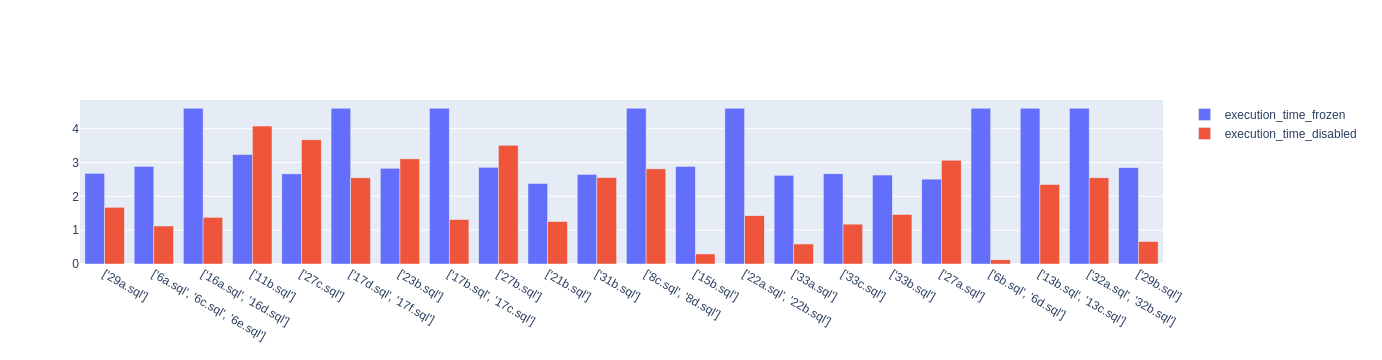

In [195]:
fig = go.Figure()
fig.add_trace(go.Bar(name='execution_time_frozen',x=df_filter['query_name'], y=abs(np.log(df_filter['lst_min_exec_with_aqo']+0.01))))
fig.add_trace(go.Bar(name='execution_time_disabled', x=df_filter['query_name'], y=abs(np.log(execution_without))))
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Planning time and execution time difference in frozen and disabled modes')
fig.show()

## query with cardinality error

In [196]:
frozen_df_query_stat_copy=frozen_df_query_stat.copy()

In [197]:
frozen_df_query_stat_copy.columns

Index(['queryid', 'cardinality_error_without_aqo_split',
       'cardinality_error_with_aqo_split', 'planning_time_without_aqo_split',
       'planning_time_with_aqo_split', 'execution_time_without_aqo_split',
       'execution_time_with_aqo_split', 'executions_with_aqo',
       'executions_without_aqo', 'min_iter_card_with', 'lst_min_val_with_aqo',
       'min_iter_card_without', 'lst_min_val_without_aqo',
       'min_iter_exec_with', 'lst_min_exec_with_aqo',
       'cardinality_error_without_aqo_split_last_value',
       'cardinality_error_with_aqo_split_last_value', 'query_name'],
      dtype='object')

In [198]:
frozen_df_query_stat_copy['diff_card_time']=frozen_df_query_stat_copy['cardinality_error_without_aqo_split_last_value']-frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']

In [199]:
frozen_df_query_stat_copy['rate_card_time']=frozen_df_query_stat_copy['cardinality_error_without_aqo_split_last_value']/frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']

In [200]:
card_rate_2x=frozen_df_query_stat_copy[frozen_df_query_stat_copy['rate_card_time']>=2]

In [201]:
card_rate_1x=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time']<2) & (frozen_df_query_stat_copy['rate_card_time']>=1)]

In [202]:
card_rate_more_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time']<1) & (frozen_df_query_stat_copy['rate_card_time']>=0)]

In [203]:
card_rate_less_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time']<0)]

In [204]:
lst_card=[len(card_rate_2x), len(card_rate_1x), len(card_rate_more_0)]

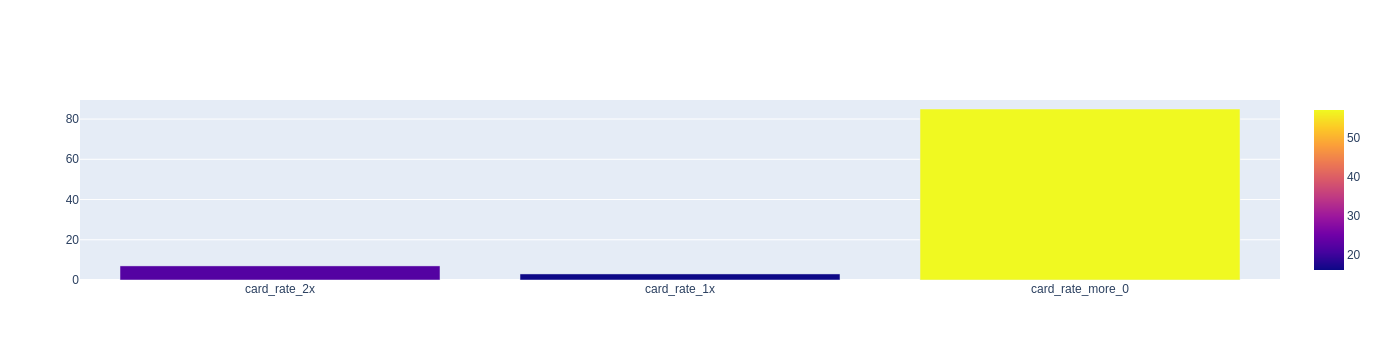

In [205]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['card_rate_2x', 'card_rate_1x', 'card_rate_more_0'], y=lst_card,
                    marker=dict(color=lst_exec, coloraxis="coloraxis")),)
fig.show()

In [206]:
card_less0_1=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']<=0.1) & (frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']>0)]
card_eq0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']==0)]
card_more0_1=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']>0.1) | (frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']<0)]

In [207]:
frozen_df_query_stat_copy

queryid                cardinality_error_without_aqo_split  \
0     988535410010893112                               [1.1920162521349358]   
1   -6651533820180303979                               [0.7105221546183831]   
2   -3414057395363075461                               [0.9142991861305755]   
3    3350265702090035455                                [3.320400539746125]   
4    -917204397272063480                               [3.2532766876167556]   
..                   ...                                                ...   
90  -6885312641126422993                                [2.432780391028795]   
91  -1889760809355916724                                [3.878764741758613]   
92  -6571914703387389993                               [1.4433860920428911]   
93   -460740518707800565                               [0.9172237323564743]   
94  -1950505845315524548  [0.9798792819060133, 0.4465750798771107, 1.066...   

                     cardinality_error_with_aqo_split  \
0   [1.4616438610722509, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1   [0.7252818076369754, 0.20549283755296058, 0.0,...   
2   [1.1885889419697482, 0.07701635339554948, 0.0,...   
3   [3.328155086529966, 2.169516763311445, 1.63167...   
4   [3.2451247839101067, 1.929014613036643, 0.9614...   
..                                                ...   
90  [2.4598668792784237, 0.14398478283858396, 0.0,...   
91  [3.8980541334568604, 2.07591186854257, 1.62768...   
92  [1.442780107563711, 0.8152581027671788, 0.3884...   
93  [0.9151338759225511, 0.400222974922172, 0.1683...   
94  [0.011538125913381528, 0.025015150933378454, 0...   

            planning_time_without_aqo_split  \
0                             [0.026226381]   
1                             [0.038574397]   
2                              [0.00951821]   
3                             [0.036294517]   
4                             [0.026380421]   
..                                      ...   
90                            [0.010389252]   
91                            [0.268594185]   
92                            [0.355609697]   
93                            [0.059932303]   
94  [0.012113558, 0.010165716, 0.007382274]   

                         planning_time_with_aqo_split  \
0   [0.025728534, 0.034151752, 0.029958985, 0.0326...   
1   [0.026729975, 0.045033516, 0.043947282, 0.0364...   
2   [0.014897705, 0.019820551, 0.019289104, 0.0211...   
3   [0.05537461, 0.063729789, 0.057718043, 0.05385...   
4   [0.040071053, 0.037738631, 0.05410122, 0.04827...   
..                                                ...   
90  [0.016478576, 0.017556968, 0.014725684, 0.0186...   
91  [2.814191886, 2.879825109, 2.803110182, 3.3700...   
92  [5.495706637, 5.5486344800000005, 5.424678184,...   
93  [0.168418759, 0.117927609, 0.113566399, 0.1187...   
94  [0.019315479, 0.018423491, 0.016807807, 0.0166...   

          execution_time_without_aqo_split  \
0                            [0.187048844]   
1                            [3.074049318]   
2                            [0.251953644]   
3                           [59.048628536]   
4                           [39.300135908]   
..                                     ...   
90                           [0.148272395]   
91                           [3.680271928]   
92                           [0.158255094]   
93                           [0.952334969]   
94  [0.219311858, 0.156207202, 0.24007977]   

                        execution_time_with_aqo_split  executions_with_aqo  \
0   [0.126813568, 0.133724676, 0.131687125, 0.1326...                   19   
1   [0.239489298, 0.243184827, 0.239045452, 0.2491...                   19   
2   [0.267958071, 0.239078817, 0.23965747, 0.24344...                   19   
3   [52.251277021, 133.378548425, 129.004908858, 1...                   19   
4   [29.479915858, 19.65142842, 28.269399508, 112....                   19   
..                                                ...                  ...   
90  [0.144502533, 0.150565069, 0.1

In [208]:
lst_card=[len(card_less0_1),len(card_eq0),len(card_more0_1)]

In [209]:
lst_card

[11, 0, 84]

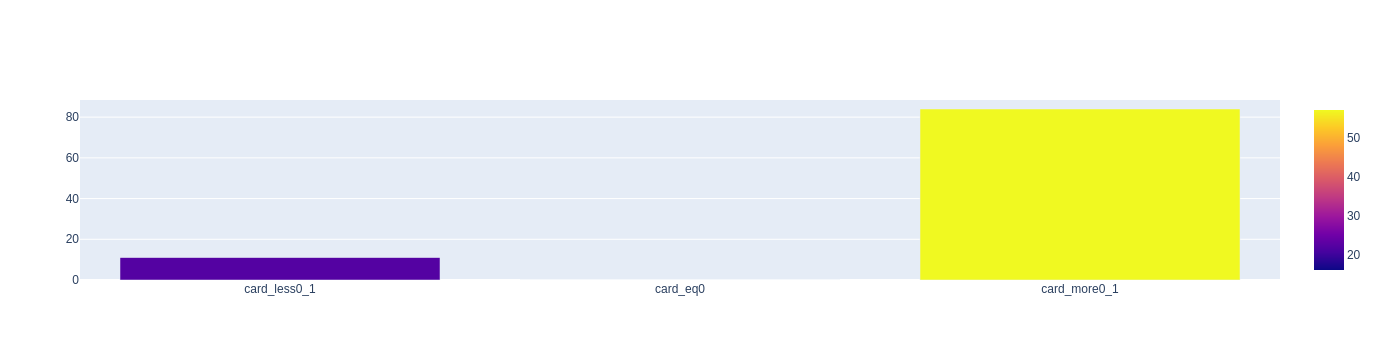

In [210]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['card_less0_1', 'card_eq0', 'card_more0_1'], y=lst_card,
                    marker=dict(color=lst_exec, coloraxis="coloraxis")),)
fig.show()

In [211]:
df_filter=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time'])>=2]

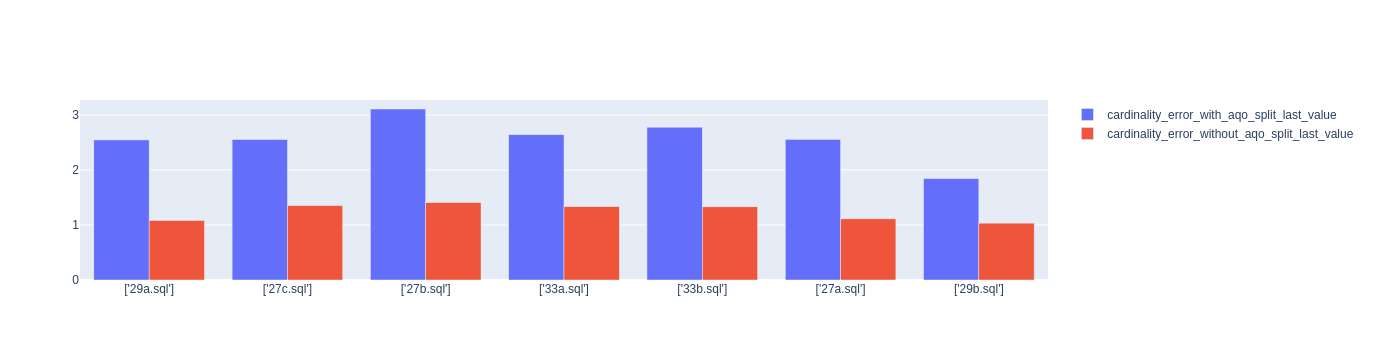

In [212]:
fig = go.Figure()
fig.add_trace(go.Bar(name='cardinality_error_with_aqo_split_last_value',x=df_filter['query_name'], y=abs(np.log(df_filter['cardinality_error_with_aqo_split_last_value']))))
fig.add_trace(go.Bar(name='cardinality_error_without_aqo_split_last_value', x=df_filter['query_name'], y=abs(np.log(df_filter['cardinality_error_without_aqo_split_last_value']))))
fig.show()

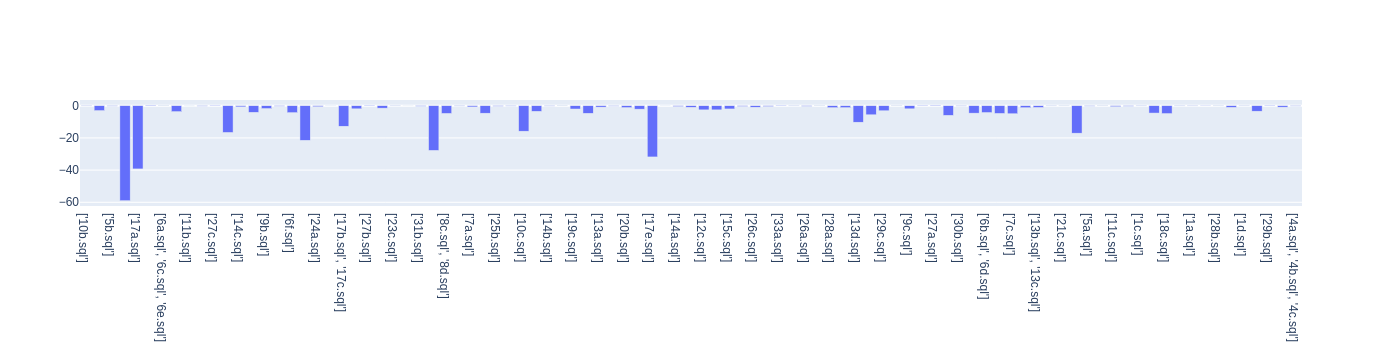

In [213]:
fig = go.Figure()
fig.add_trace(go.Bar(name='cardinality_error',x=frozen_df_query_stat_copy['query_name'], y=frozen_df_query_stat_copy['diff_card_time']))
fig.show()